# All plots and Data Analysis used in the Sim Storm Paper

Please make sure to run ProcessSamiData.py in utility_programs before running anything here

## Imports

In [1]:
import aacgmv2, time
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math, os, shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.io import readsav
import pymap3d as pm
import glob
import datetime, statistics
from aetherpy.io import read_routines
from math import cos, radians, sin, sqrt
from scipy import spatial, signal

from spacepy.coordinates import Coords
from spacepy.time import Ticktock
import fnmatch


from mpl_toolkits.basemap import Basemap

from scipy.interpolate import LinearNDInterpolator, interp1d

%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Settings

In [129]:
dtime_storm_start = datetime.datetime(2011,5,21,13,40) 
plot_start_delta  = 4   #hours before storm onset to start making plots
plot_end_delta    = 10  # hours after storm onset to end plots. Set to -1 to run for the whole time


gitm_cols = ['Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))', 'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', '[e-]', 'eTemperature', 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)'] # which gitm columns do you want plotted?


gitm_path = "/home/axb170054/scratch/GITM-testing/test_folders/step_function_driving/SAMI3-stretch/gitm_data/"


gitm_alt_idxs = [7,15,30,40] #set this to -1 if you want all columns
gitm_keo_lons = [-90,2,90,-178]


num_pool_workers = 10 # number of workers to use in multithreading jobs. Set to 1 if you don't know what this means.

available gitm cols are:
    ['Longitude', 'Latitude', 'Altitude', 'Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))', 'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', '[e-]', 'eTemperature', 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)']

## Set up some useful functions:

In [235]:
# This will be used in plotting:
gitm_colnames_friendly = {'Rho': 'Neutral Density', '[O(!U3!NP)]': 'O(3)', '[O!D2!N]': 'O2', '[N!D2!N]': 'N2', '[N(!U4!NS)]': 'N(4S)', '[NO]': 'NO', '[He]': 'He', '[N(!U2!ND)]': 'N(2)', '[N(!U2!NP)]': 'N(2)', '[H]': 'H', '[CO!D2!N]': 'CO2', '[O(!U1!ND)]': 'O(1)', 'Temperature': 'Temperature', 'V!Dn!N(east)': 'Vn(east)', 'V!Dn!N(north)': 'Vn(north)', 'V!Dn!N(up)': 'Vn(up)', 'V!Dn!N(up,O(!U3!NP))': 'Vn(up,O(3))', 'V!Dn!N(up,O!D2!N)': 'Vn(up,O2)', 'V!Dn!N(up,N!D2!N)': 'Vn(up,N2)', 'V!Dn!N(up,N(!U4!NS))': 'Vn(up,N(4S))', 'V!Dn!N(up,NO)': 'Vn(up,NO)', 'V!Dn!N(up,He)': 'Vn(up,He)', '[O_4SP_!U+!N]':'O4S+', '[NO!U+!N]': 'NO+', '[O!D2!U+!N]': 'O2+', '[N!D2!U+!N]': 'N2+', '[N!U+!N]': 'N+', '[O(!U2!ND)!U+!N]': 'O(2)+', '[O(!U2!NP)!U+!N]': 'O(2)+', '[H!U+!N]': 'H+', '[He!U+!N]': 'He+', '[e-]': 'e-', 'eTemperature': 'eTemperature', 'iTemperature': 'iTemperature', 'V!Di!N(east)': 'Vi(east)', 'V!Di!N(north)': 'Vi(north)', 'V!Di!N(up)': 'Vi(up)'}

In [119]:
def read_in_gitm_file(f_idx):
    f = gitm_files[f_idx]
    gitm_df = pd.DataFrame()

    gitm_f = read_routines.read_gitm_file(f)
    gitm_df['alt'] = gitm_f[2].flatten()
    gitm_df['lat'] = np.rad2deg(gitm_f[1].flatten())
    gitm_df['lon'] = np.rad2deg(gitm_f[0].flatten())
    gitm_df['dtime'] = [gitm_dtimes[f_idx]] * len(gitm_df)

    for col in gitm_cols:
        col_idx = gitm_f['vars'].index(col)
        gitm_df[col] = gitm_f[col_idx].flatten()

    if gitm_alt_idxs != -1:
        list_of_dfs = []
        indiv_alts = np.sort(list(set(gitm_df.alt)))
        for alt_idx in gitm_alt_idxs:
            list_of_dfs.append(gitm_df.loc[np.where(gitm_df['alt'] == indiv_alts[alt_idx])])
        gitm_df = pd.concat(list_of_dfs, ignore_index = True).reset_index(drop = True)
    # shift lons b/c gitm gors from 0->360 but we need -180->180. Also get rid of ghost cells.
    gitm_df = gitm_df[(gitm_df.lon < 360) & (gitm_df.lon > 0)].reset_index(drop = True)
    new_lons = []
    for l in gitm_df.lon:
        if l > 180:
            new_lons.append(l - 360)
        else:
            new_lons.append(l)
    gitm_df.lon = new_lons
    gitm_df = gitm_df[(np.abs(gitm_df.lat) < 90)].reset_index(drop = True)
    return gitm_df

In [164]:
def bandpass_filter(noisy_signal):
    sampling_frequency = 1/(5*60)  # Sampling frequency (in Hz) #5 mins
    low_cutoff_frequency = 1/(90*60)  # Low cutoff frequency (in Hz) #90 mins
    high_cutoff_frequency = 1/(50*60)  # High cutoff frequency (in Hz) #50 mins

    coefficients = signal.butter(4, [low_cutoff_frequency, high_cutoff_frequency], btype='bandpass', fs=sampling_frequency)
    bps = np.array(signal.filtfilt(coefficients[0], coefficients[1], noisy_signal))
    return bps

## Do GITM Plots First

In [5]:
gitm_files = np.sort(glob.glob(gitm_path+'3DALL*'))

gitm_dtimes = []
for i in gitm_files:
    yy, MM, dd, hr, mm, sec = i[-17:-15], i[-15:-13], i[-13:-11], i[-10:-8], i[-8:-6], i[-6:-4]
    gitm_dtimes.append(datetime.datetime(int('20' + yy), int(MM), int(dd), int(hr), int(mm), int(sec)))
    
storm_start_index = np.argmin(np.abs(np.array(gitm_dtimes)-dtime_storm_start))
plot_start_idx = np.argmin(np.abs(np.array(gitm_dtimes)-(dtime_storm_start - datetime.timedelta(hours = plot_start_delta))))
plot_end_idx = np.argmin(np.abs(np.array(gitm_dtimes)-(dtime_storm_start + datetime.timedelta(hours = plot_end_delta)))) if plot_end_delta != -1 else -1

### Read in all gitm files

In [174]:
with Pool(num_pool_workers) as pool:
    df = pool.map(read_in_gitm_file, list(range(plot_start_idx, plot_end_idx)))
    
df = pd.concat(df, ignore_index = True).reset_index(drop = True)

lats, lons, alts  = np.unique(df.lat), np.unique(df.lon), np.unique(df.alt)

times = np.unique(df.dtime)

### Keograms! of all columns!

In [210]:
times[0], times[0].astype(datetime.datetime), np.datetime64(dtime_storm_start)

(numpy.datetime64('2011-05-21T09:40:00.000000000'),
 1305970800000000000,
 numpy.datetime64('2011-05-21T13:40:00.000000'))

In [121]:
lats, lons, alts

(array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5,
        -80.5, -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5,
        -71.5, -70.5, -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5,
        -62.5, -61.5, -60.5, -59.5, -58.5, -57.5, -56.5, -55.5, -54.5,
        -53.5, -52.5, -51.5, -50.5, -49.5, -48.5, -47.5, -46.5, -45.5,
        -44.5, -43.5, -42.5, -41.5, -40.5, -39.5, -38.5, -37.5, -36.5,
        -35.5, -34.5, -33.5, -32.5, -31.5, -30.5, -29.5, -28.5, -27.5,
        -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18.5,
        -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,  -9.5,
         -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
          0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
      

In [229]:
hrs_since_storm = np.array([i - np.datetime64(dtime_storm_start) for i in times]).astype(int)/1e9/3600

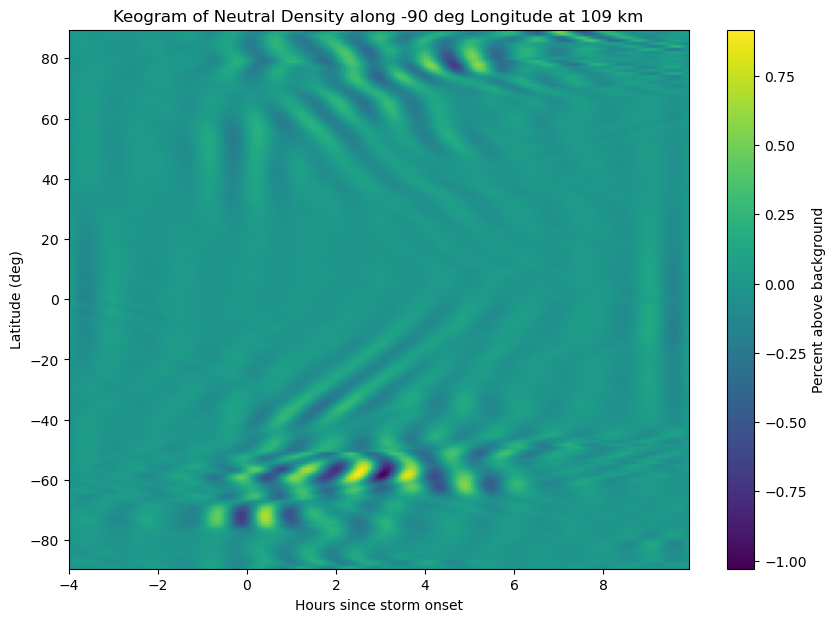

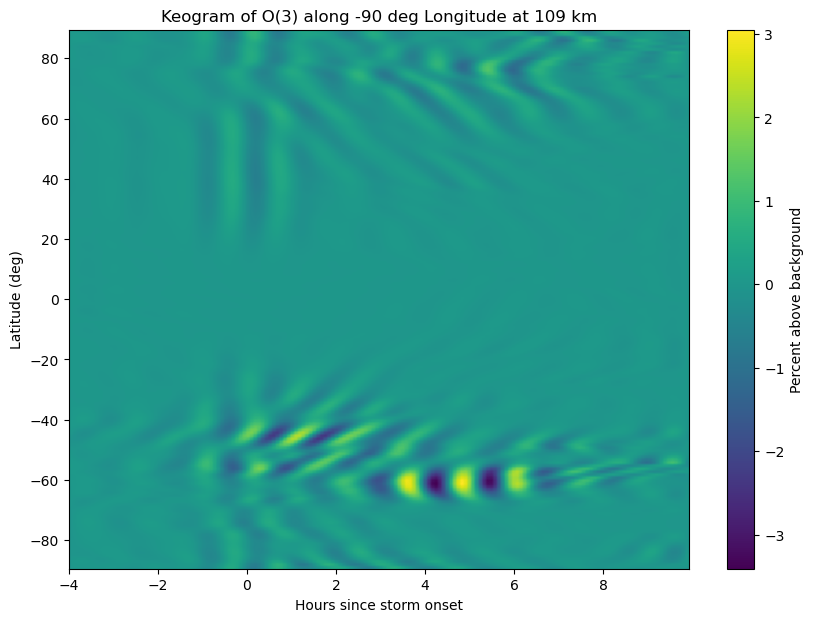

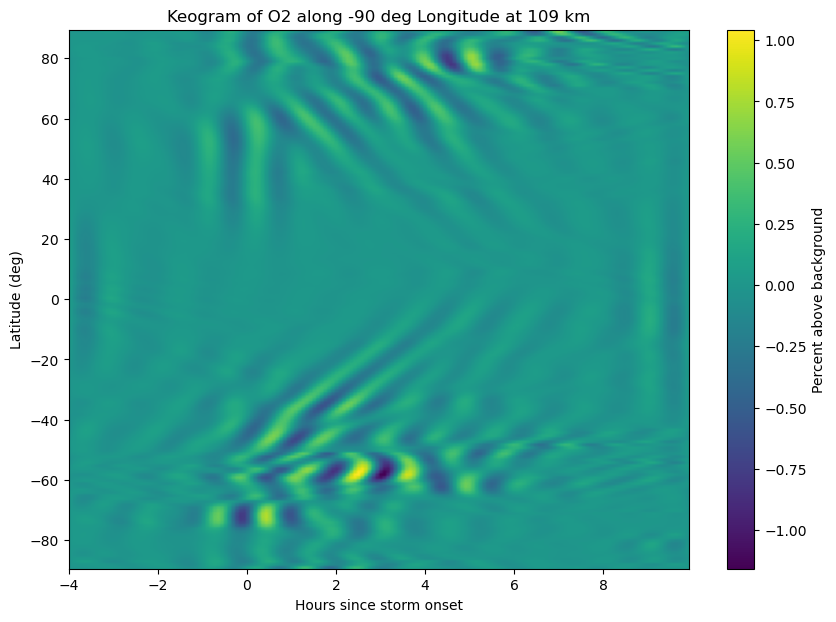

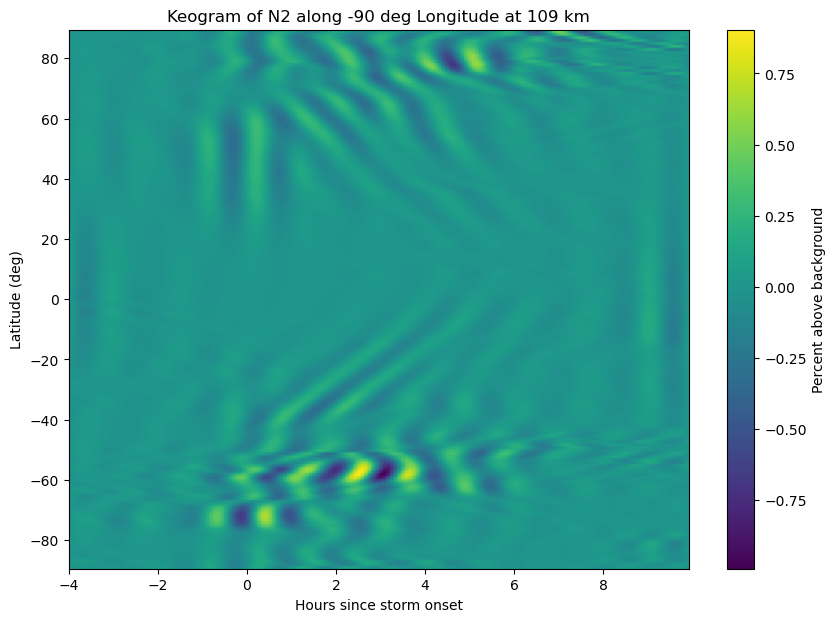

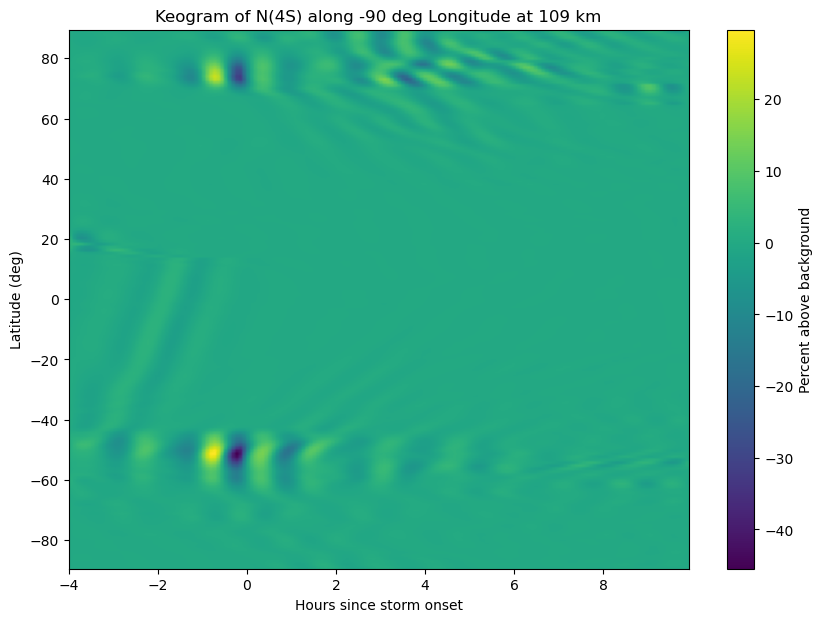

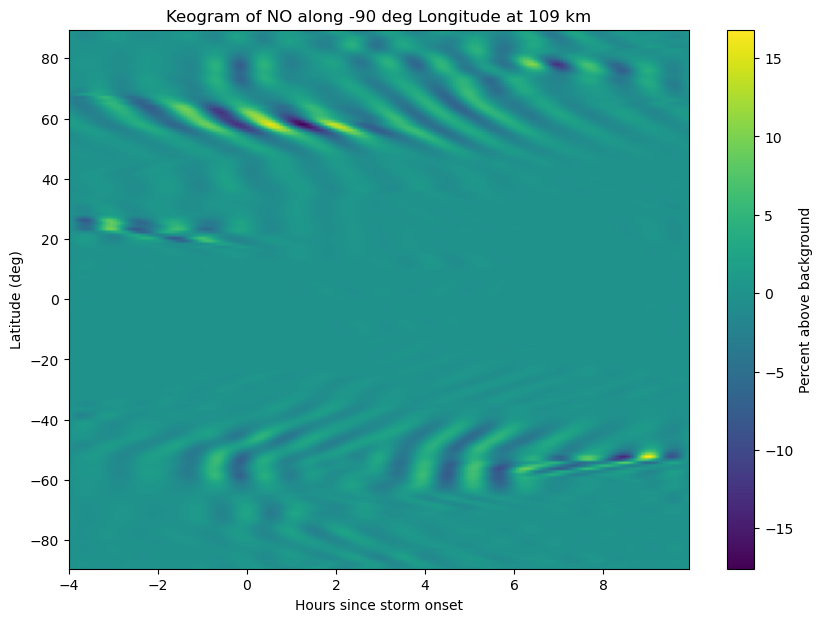

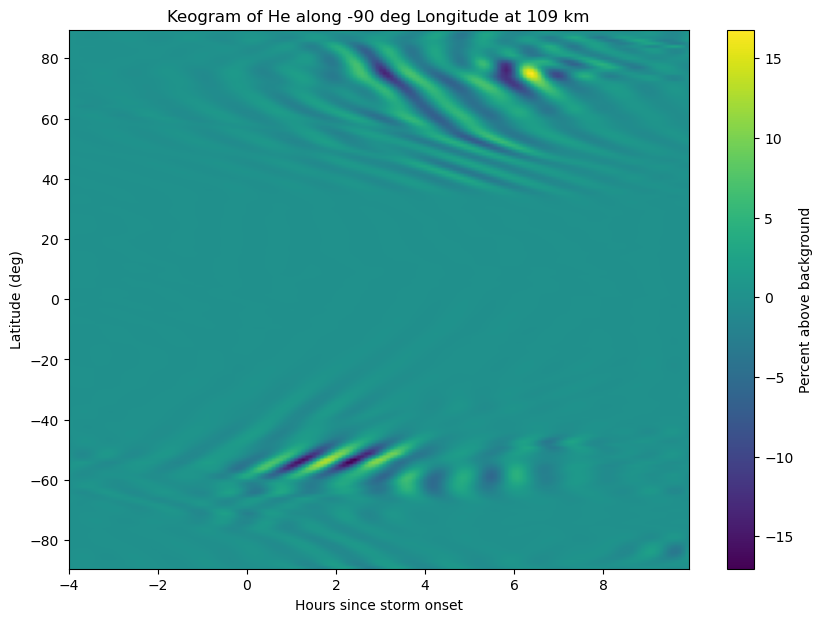

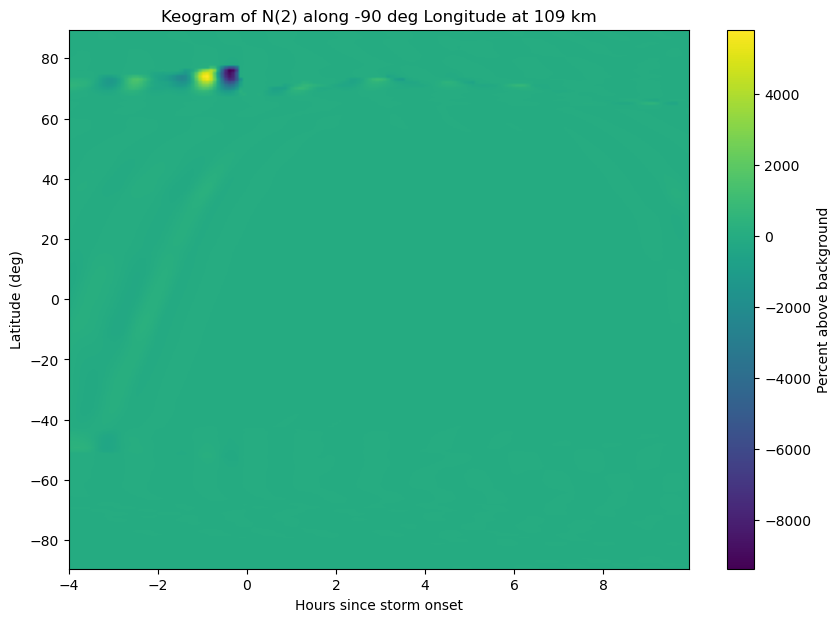

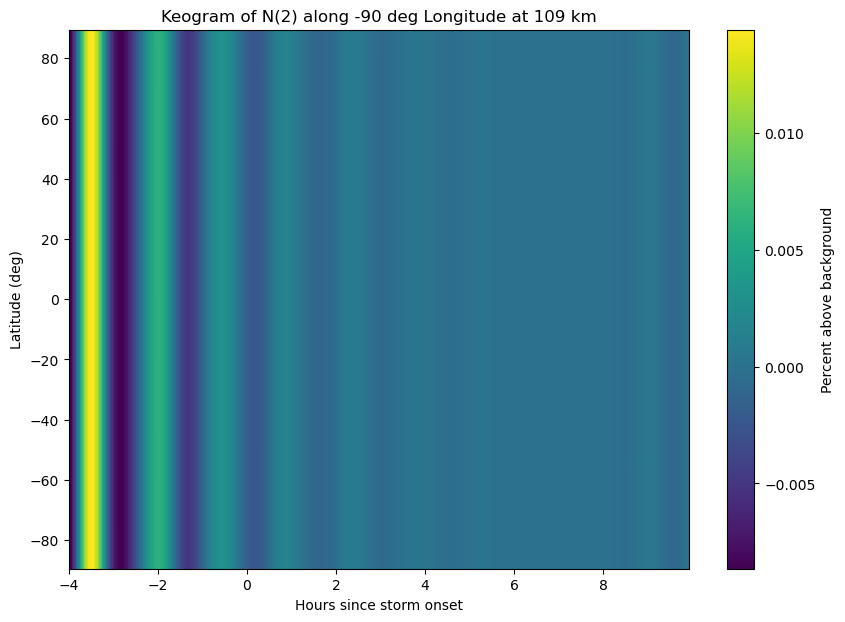

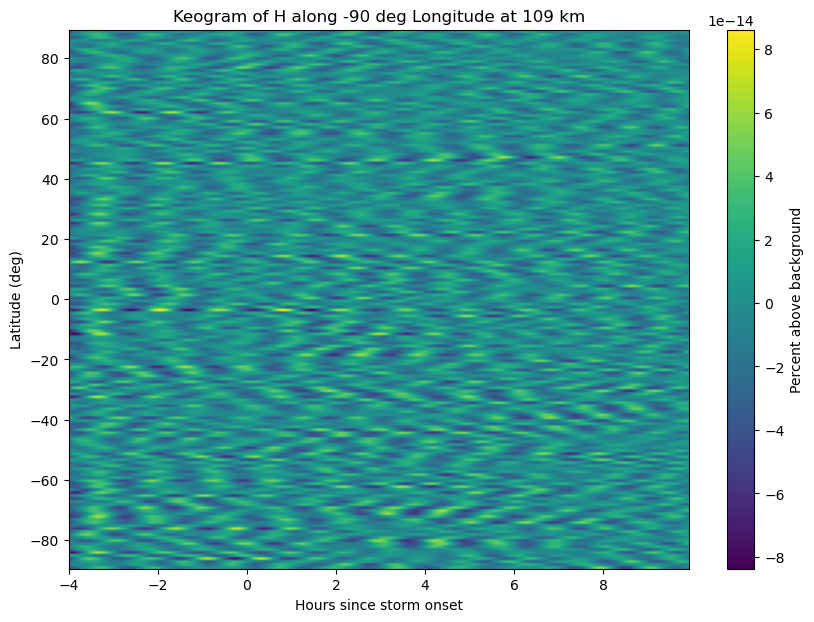

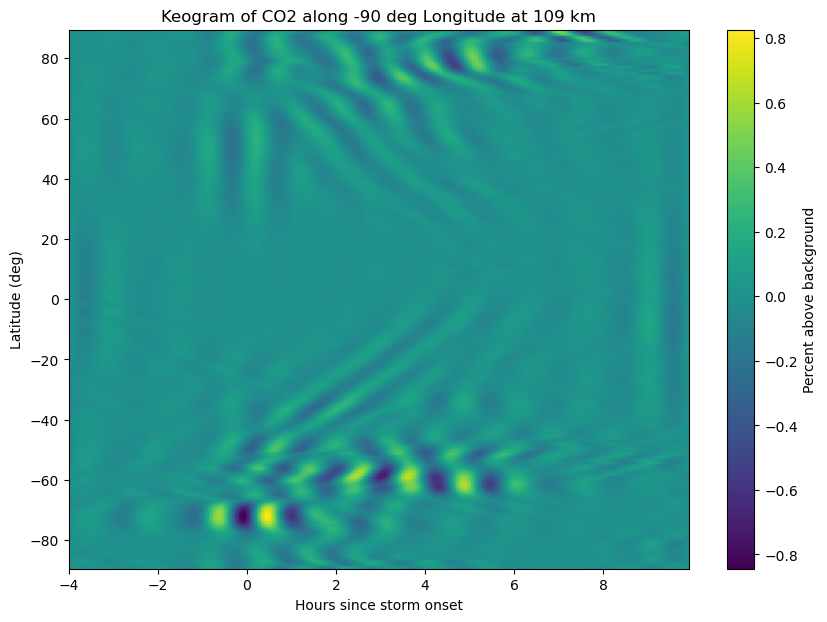

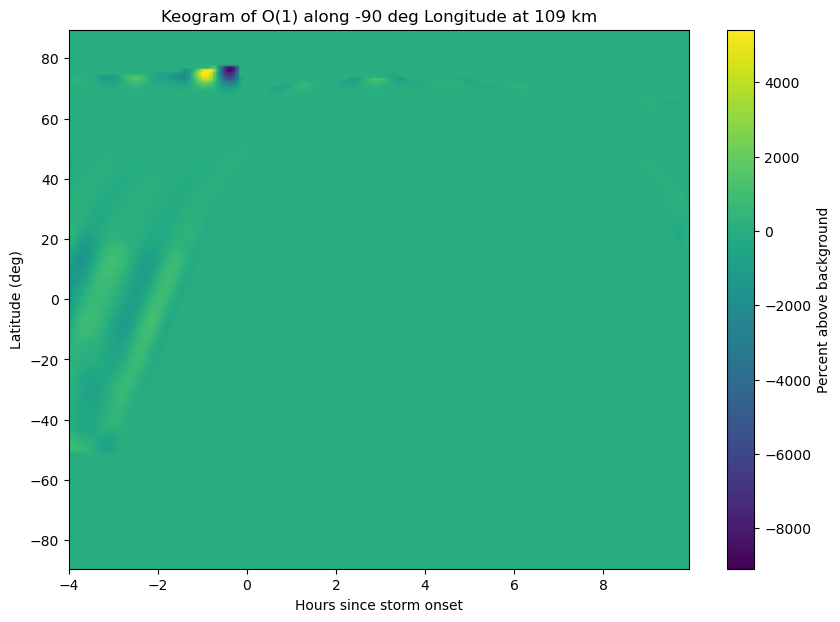

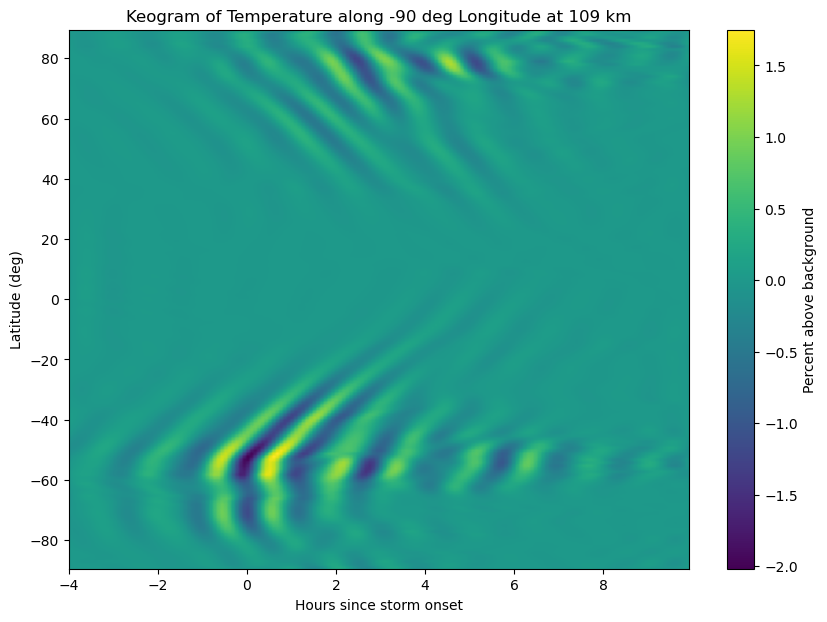

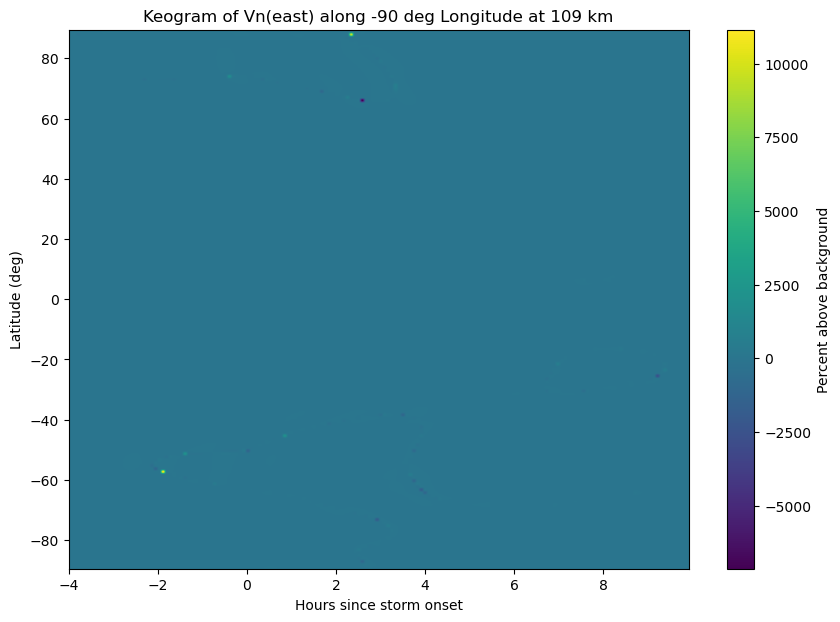

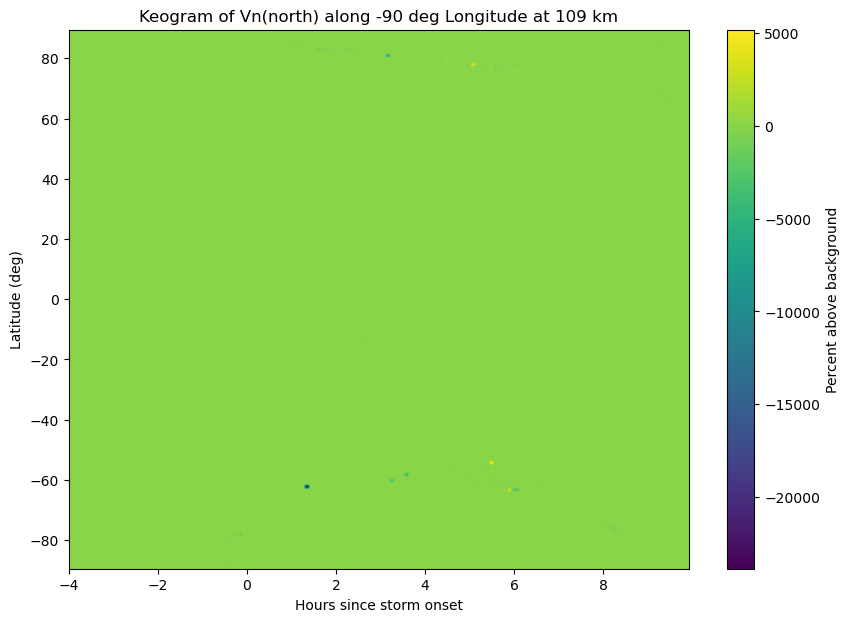

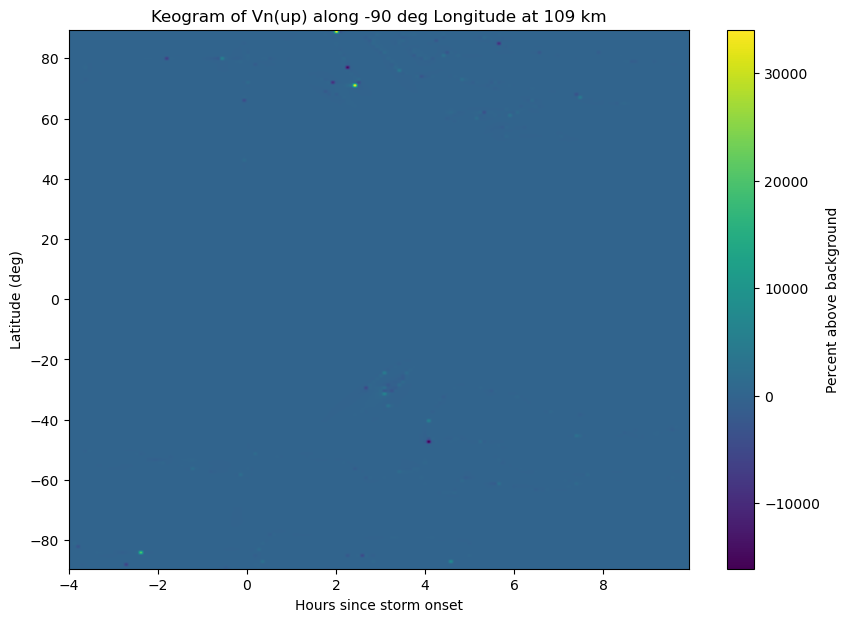

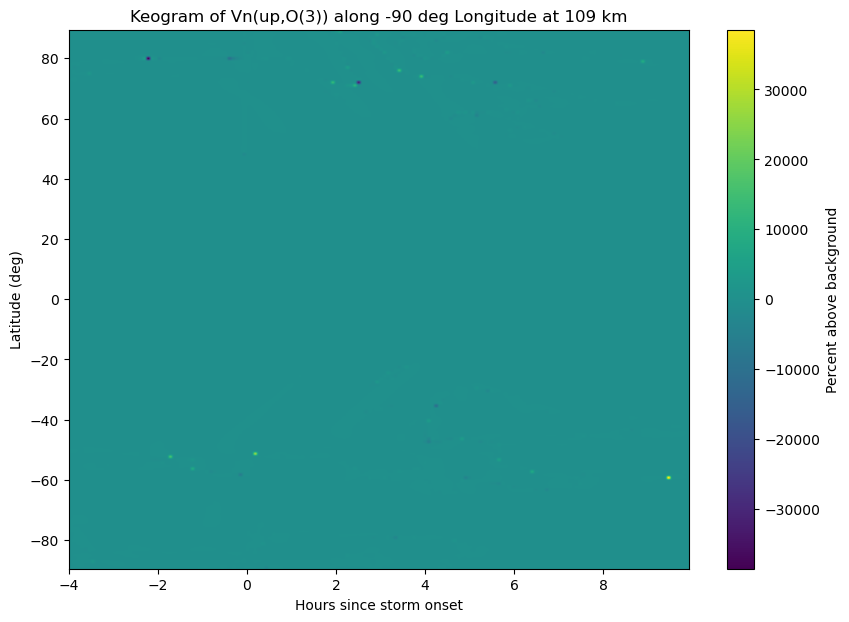

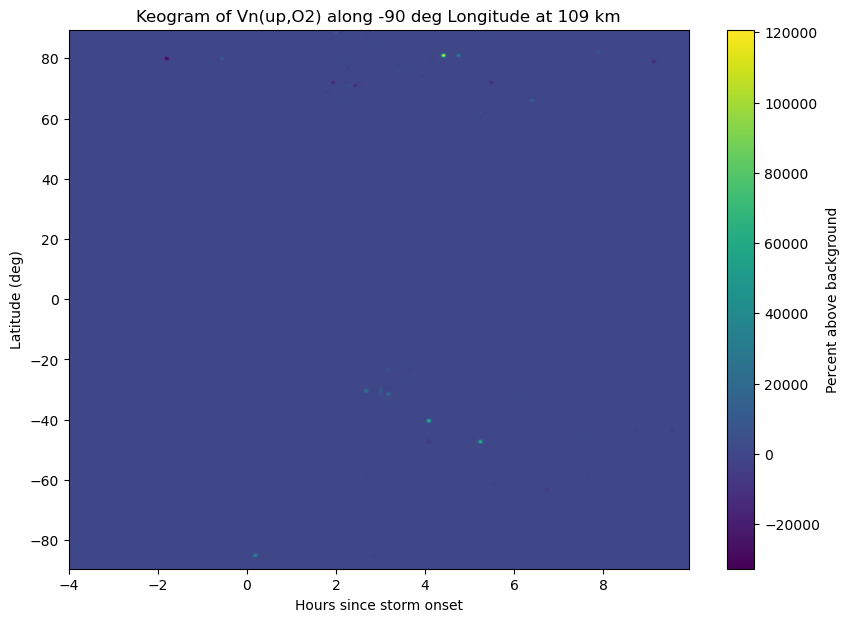

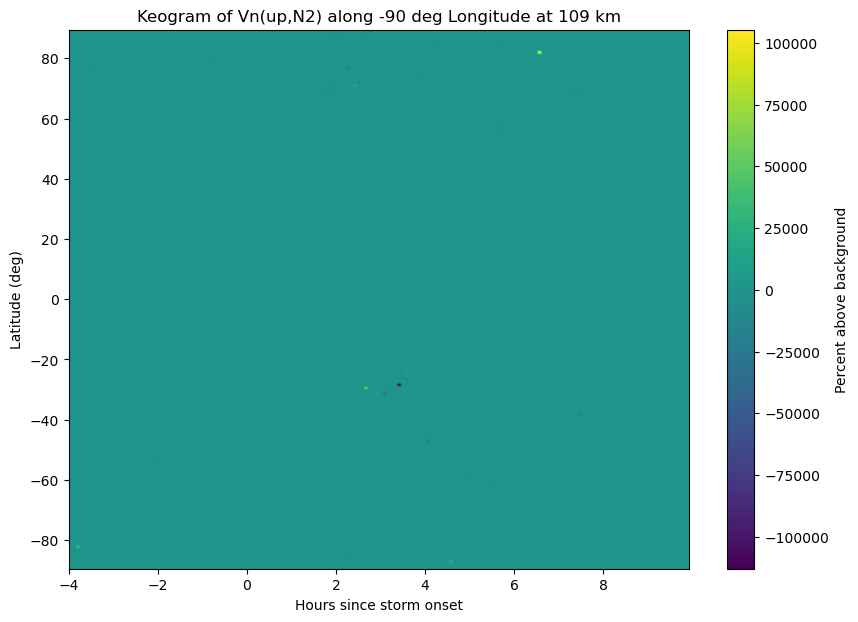

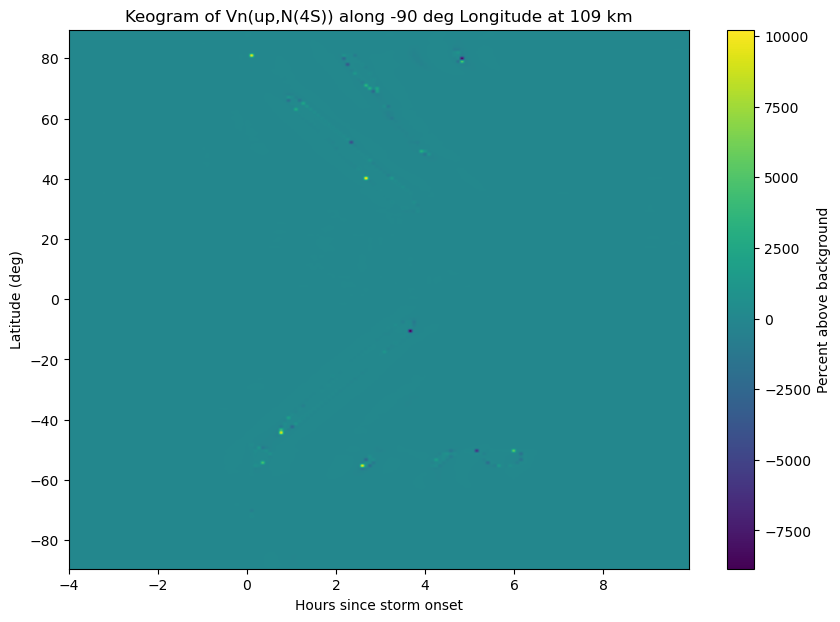

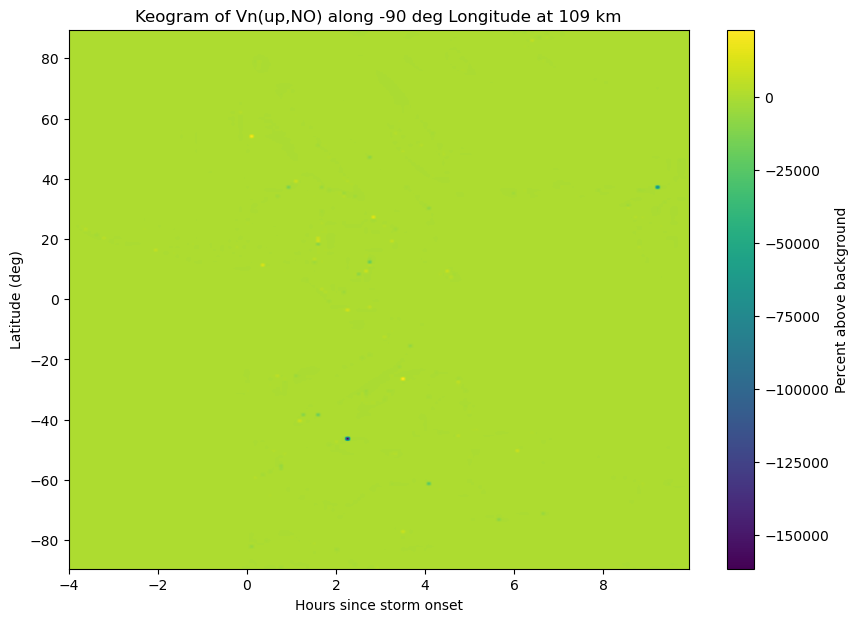

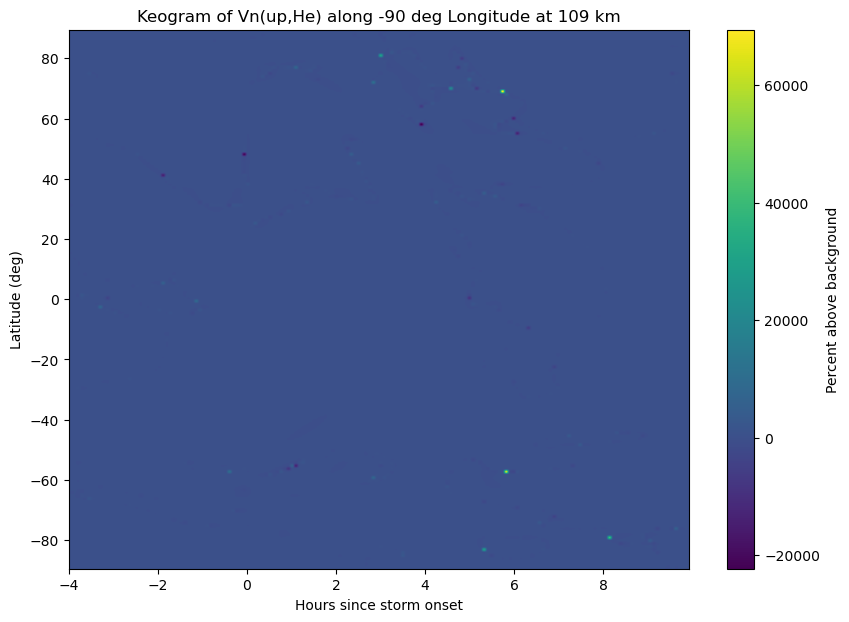

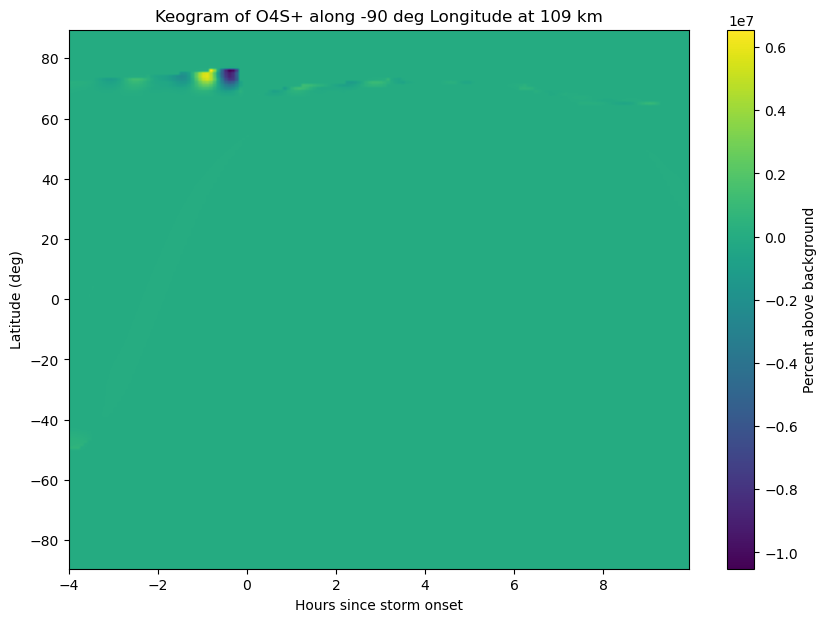

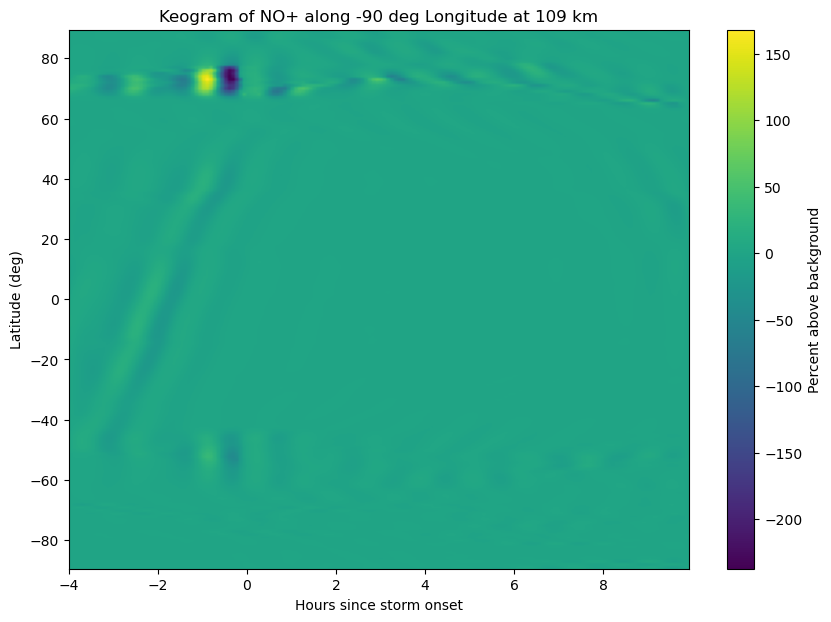

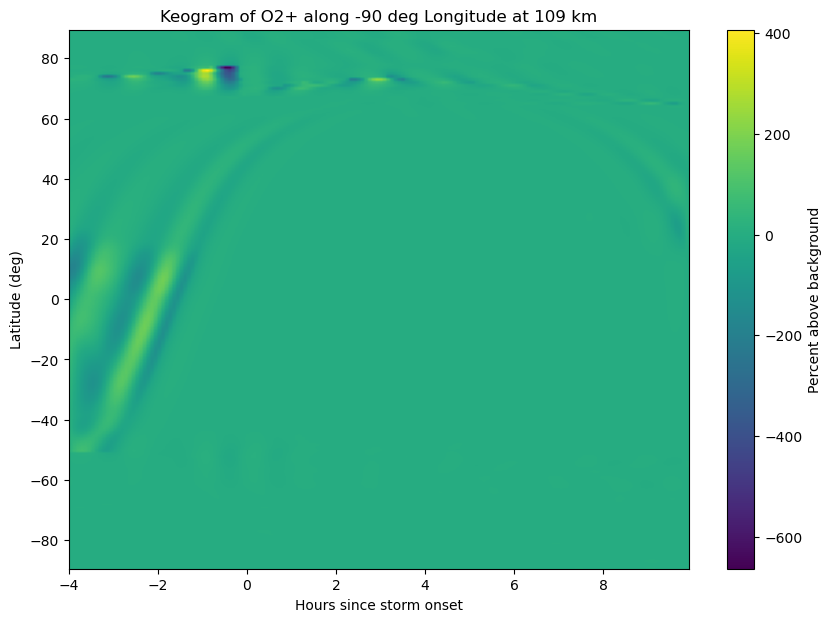

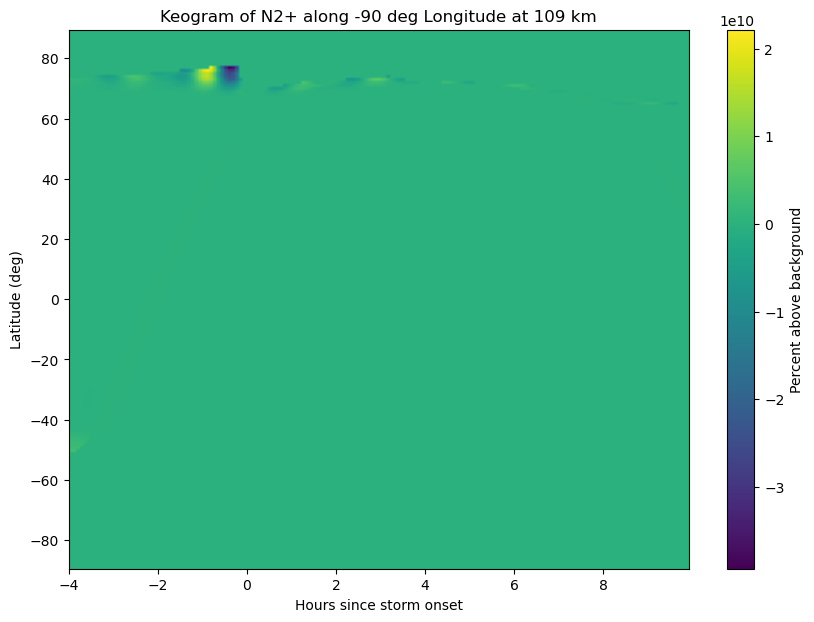

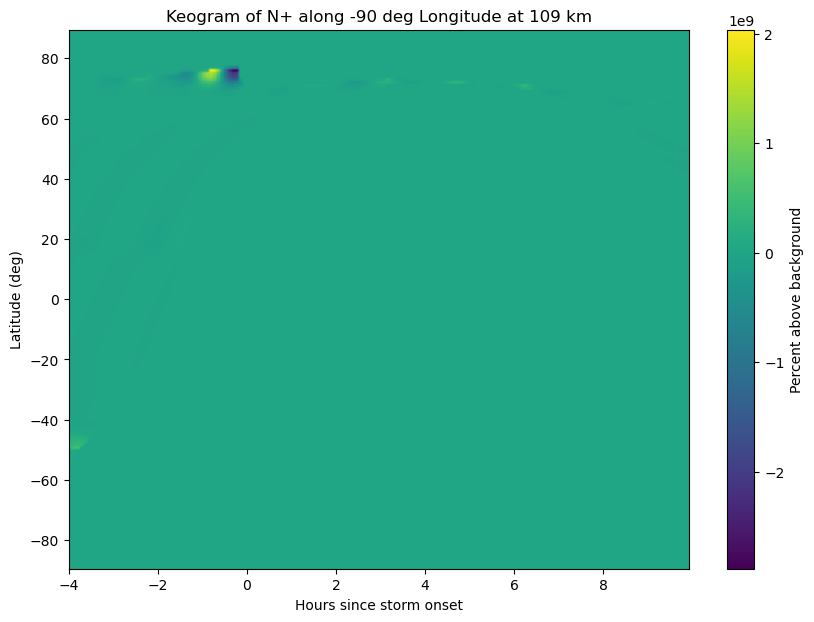

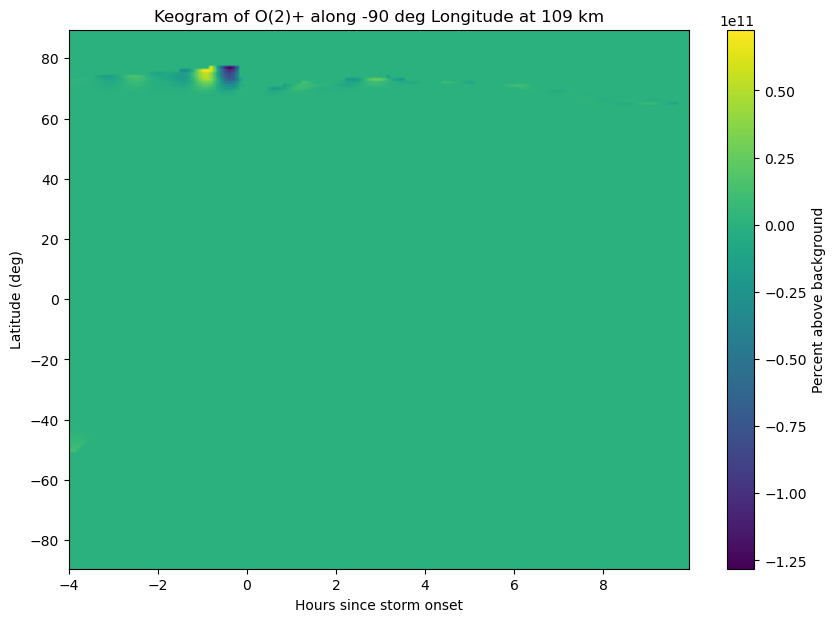

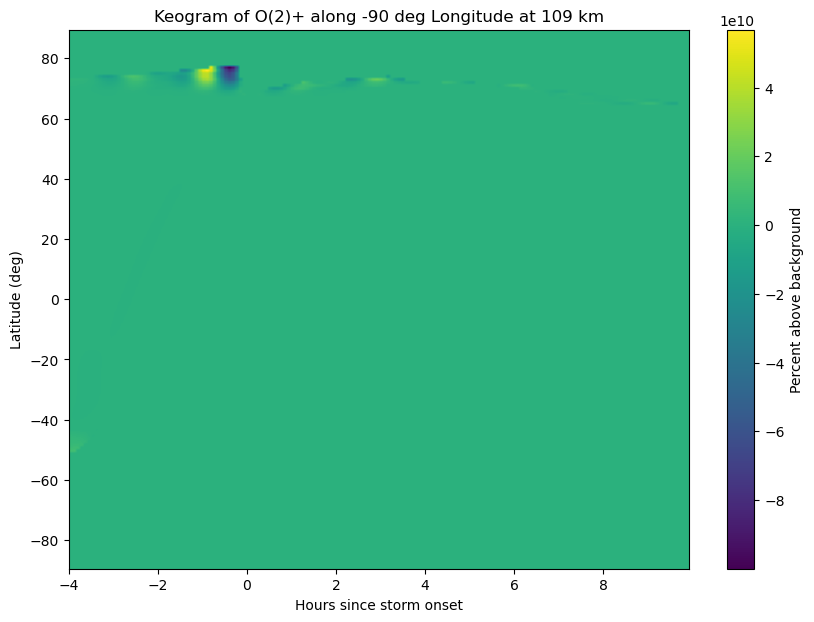

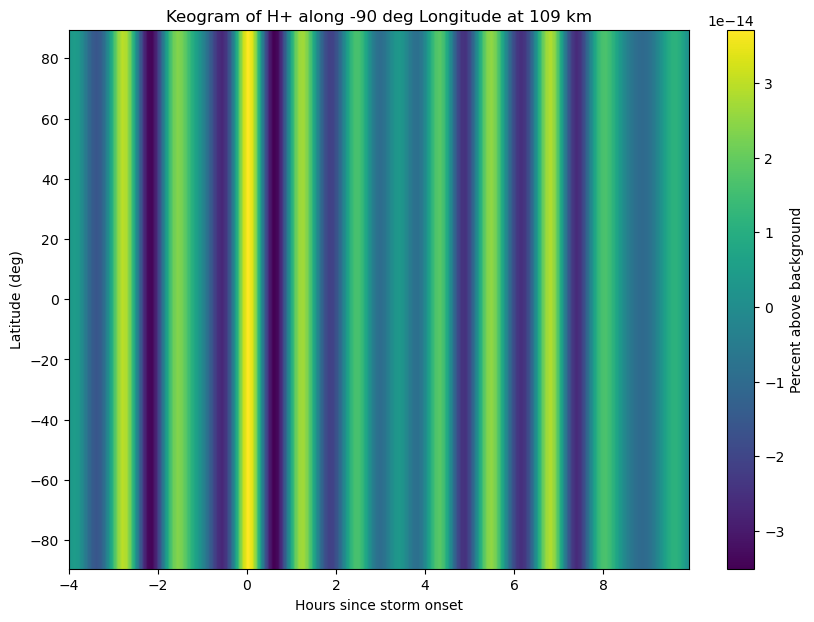

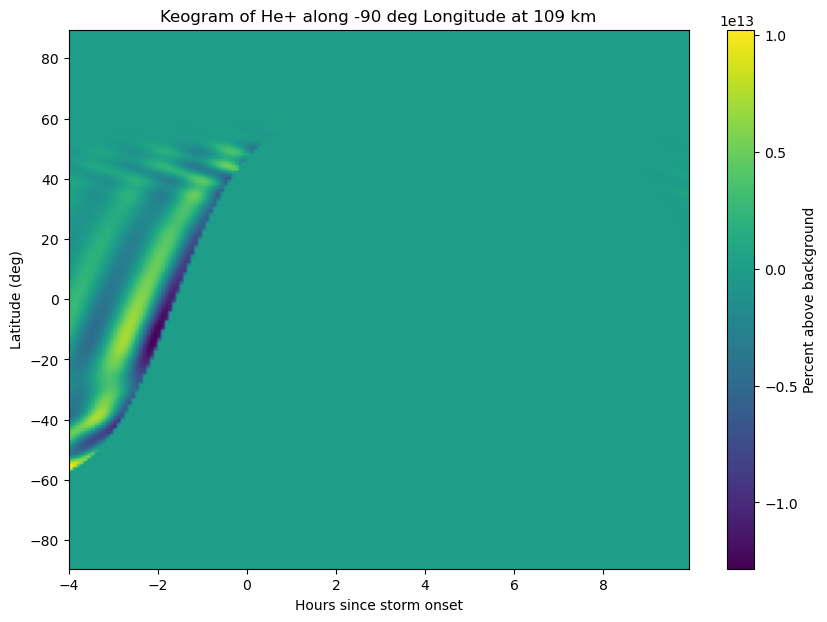

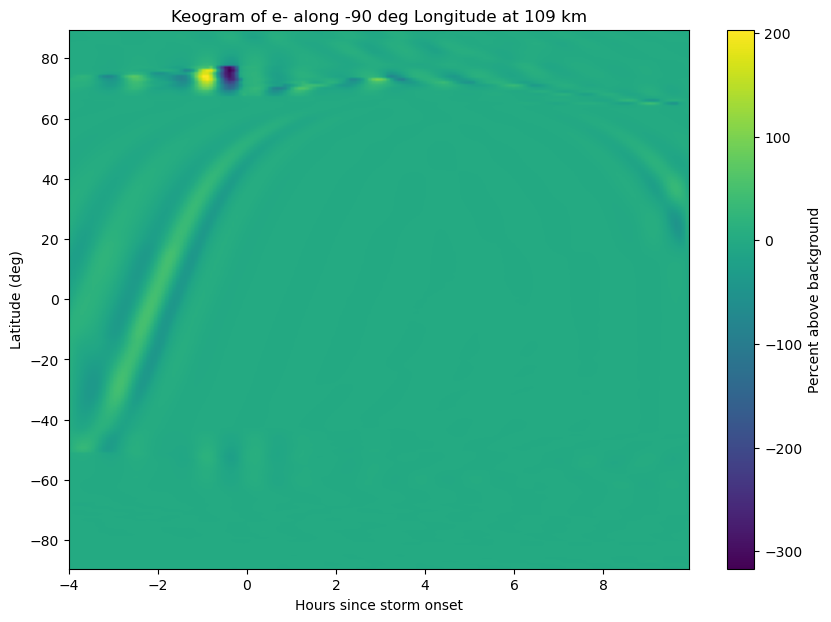

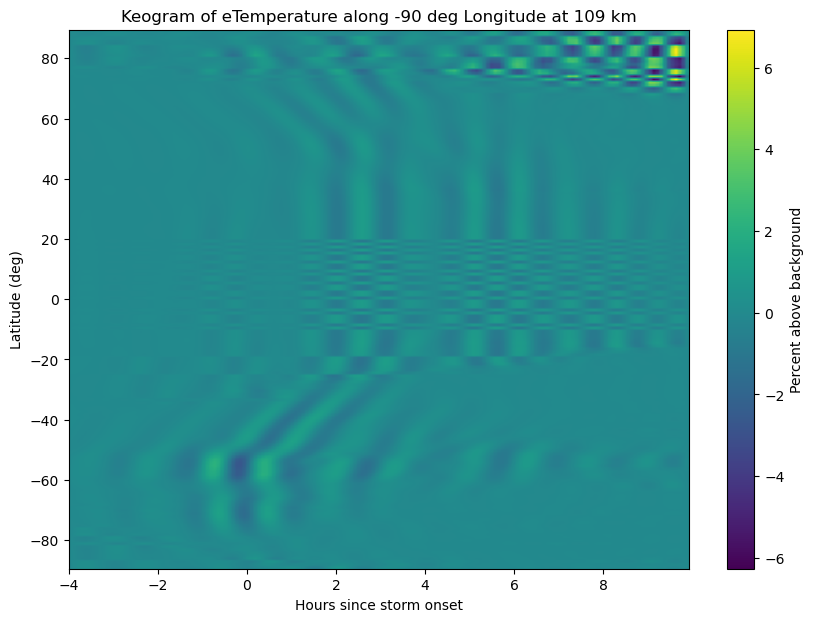

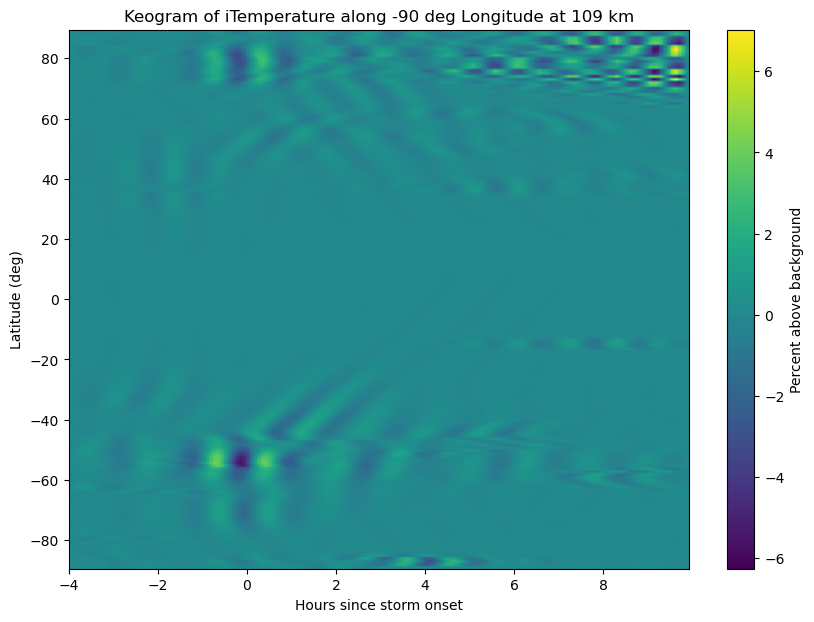

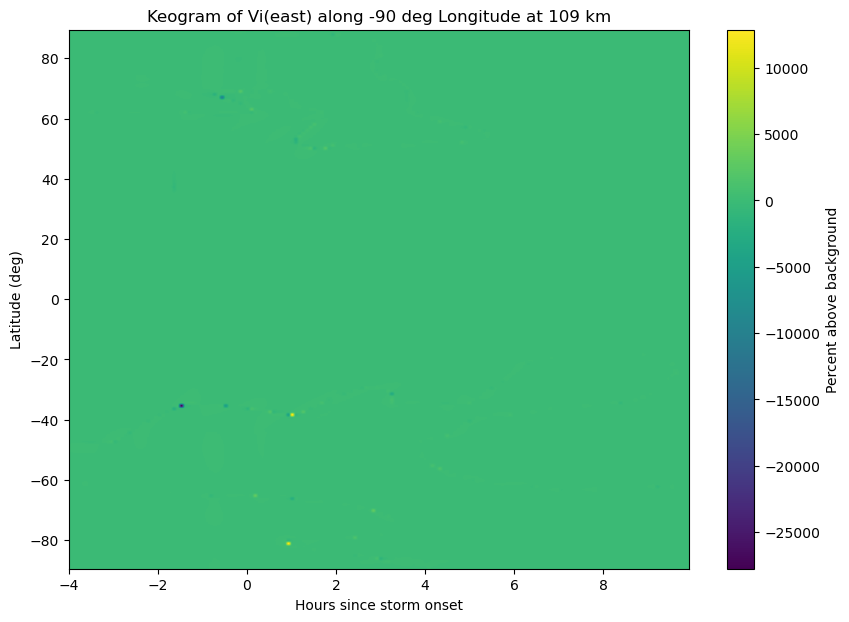

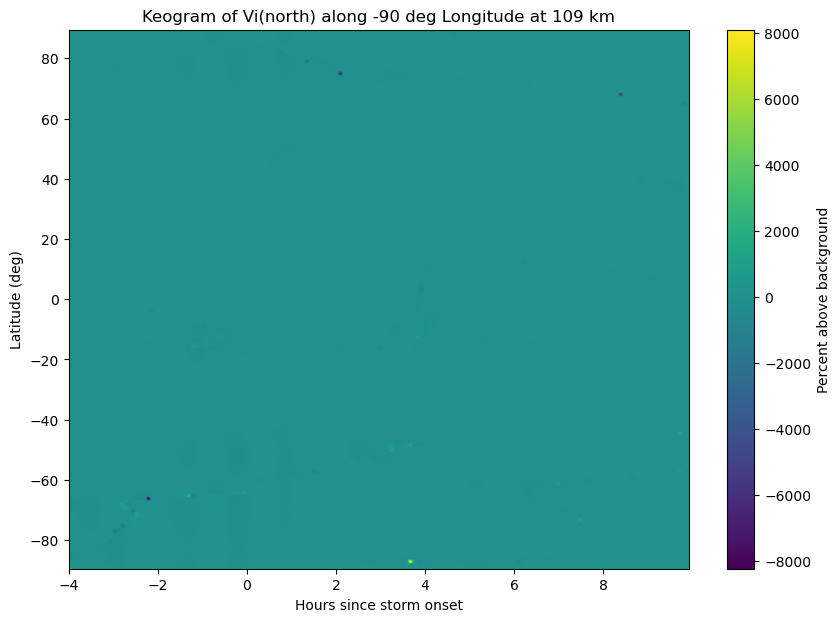

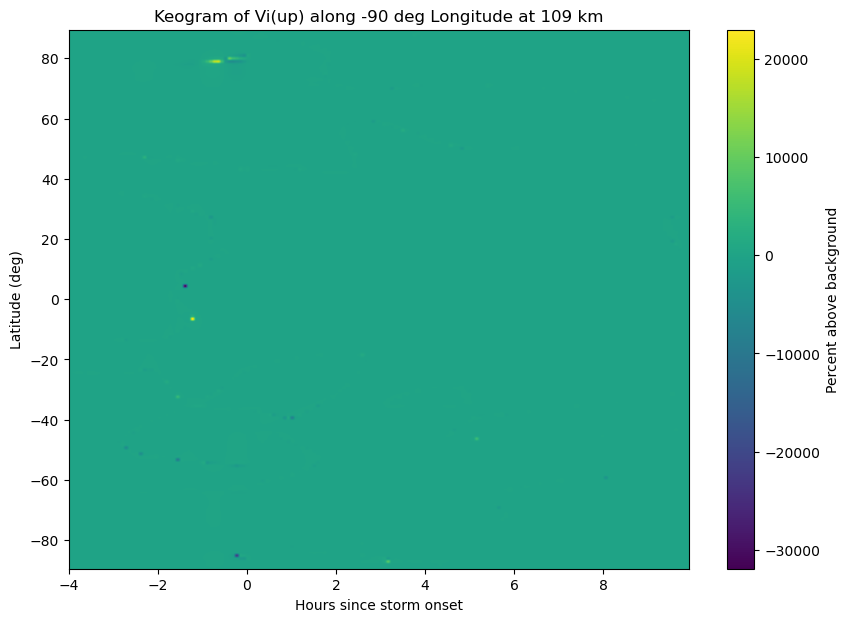

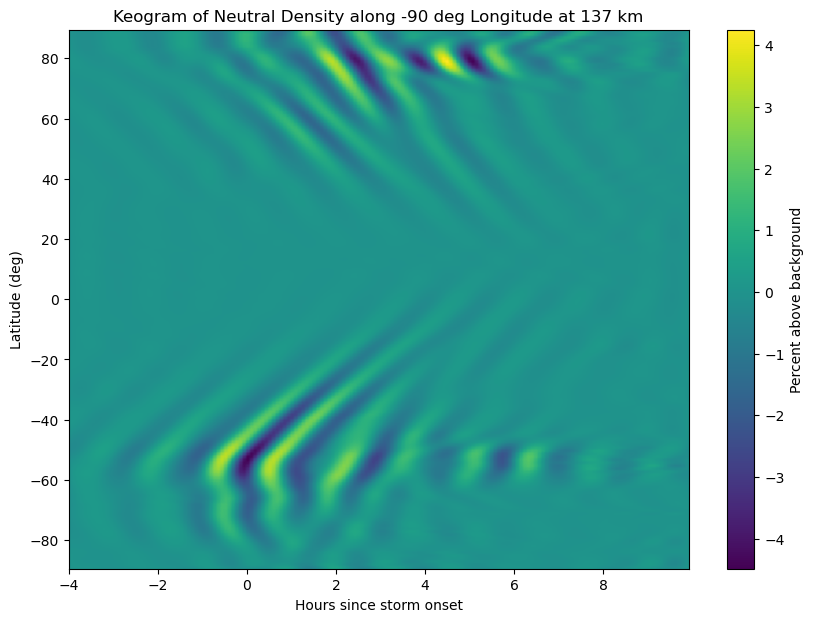

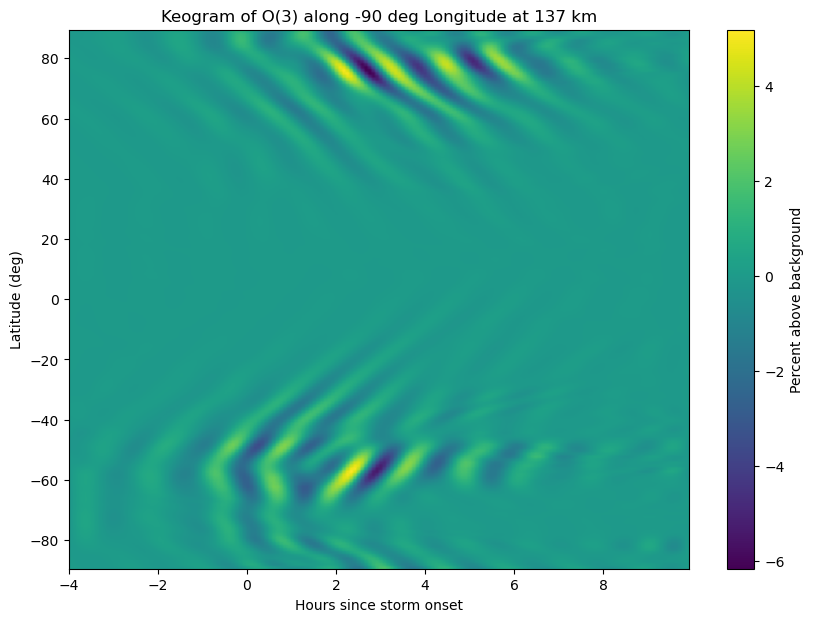

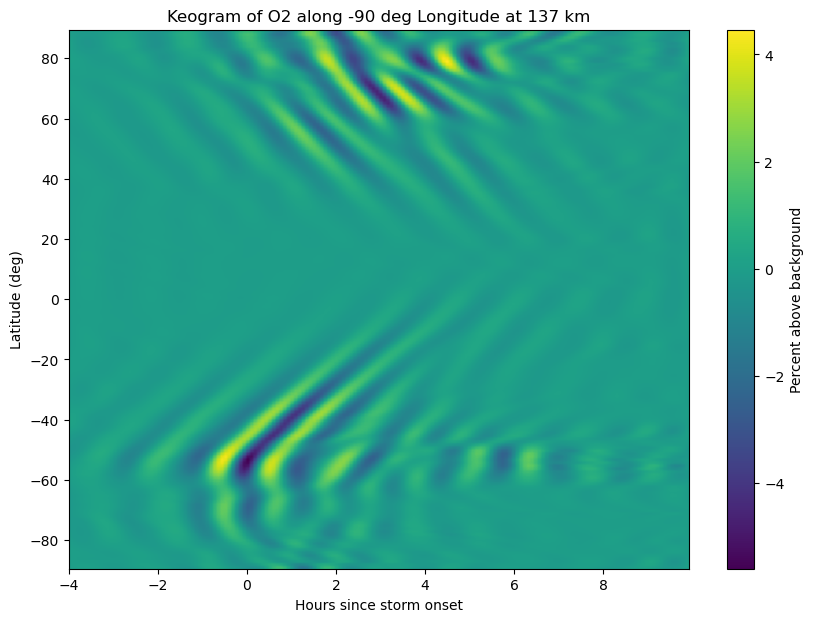

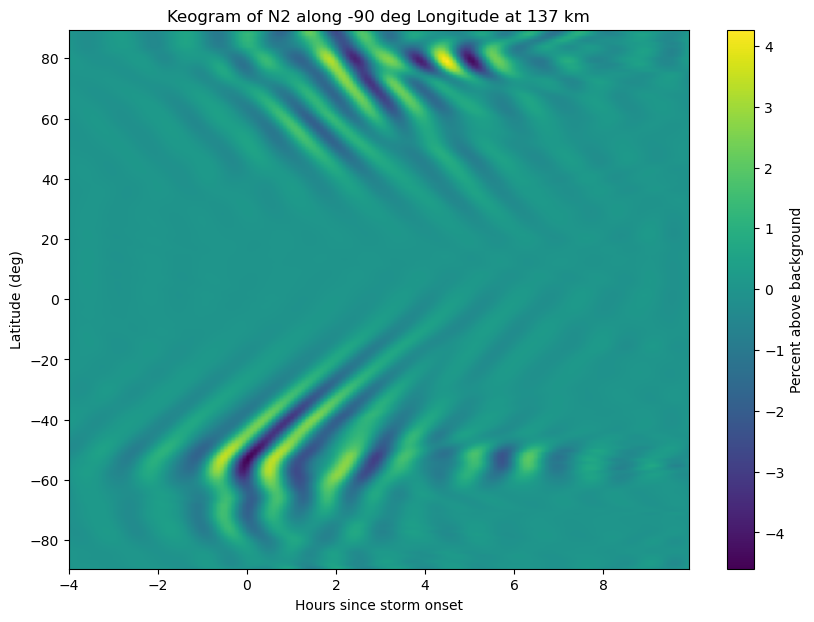

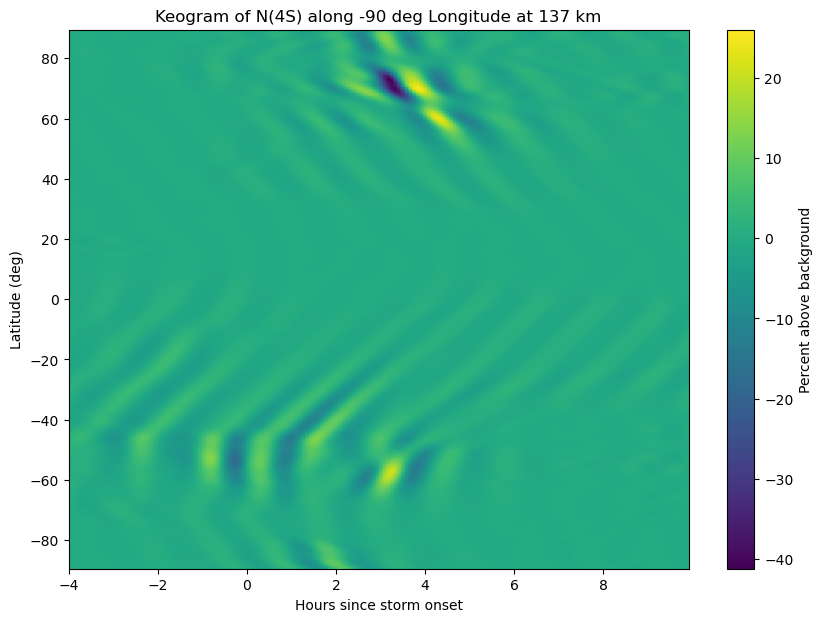

KeyboardInterrupt: 

In [245]:
for ilon in gitm_keo_lons:
    for ialt in alts:
        df_sel = df[(df.alt == ialt) & (df.lon.astype('int') == ilon)].reset_index(drop = True)
        
        for icol in gitm_cols:
            bandpass = []
            for ilat in lats:
                df_sel_lat = df_sel[df_sel.lat == ilat].reset_index(drop = True)
                bandpass.append((bandpass_filter(df_sel_lat[icol])/df_sel_lat[icol])*100)
            plt.figure(figsize = (10,7))
            plt.imshow(bandpass, extent = [min(hrs_since_storm), max(hrs_since_storm), min(lats), max(lats)], aspect = 'auto', cmap = 'viridis')
            plt.ylabel('Latitude (deg)')
            plt.xlabel('Hours since storm onset')
            plt.title('Keogram of %s along %i deg Longitude at %i km' %(gitm_colnames_friendly[icol], ilon, round(ialt/1000,0)))
            plt.colorbar(label = 'Percent above background')
            plt.show()
            plt.close()
            
            


### Now map time

In [122]:
df_loc = df[(df.dtime == datetime.datetime(2011,5,21,14,55)) & (df.alt == alts[2])]

In [123]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

<AxesSubplot:xlabel='lon', ylabel='lat'>

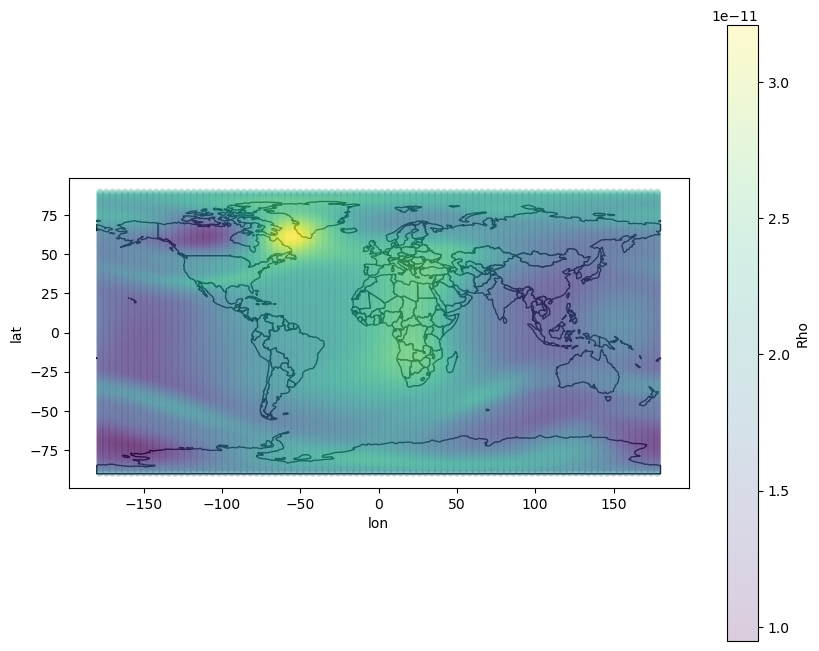

In [124]:
fig,ax = plt.subplots(figsize = (10,8))
world.plot(ax = ax, color = 'white', edgecolor = 'black')
df_loc.plot(ax = ax, x = 'lon', y = 'lat', c = 'Rho', kind = 'scatter', colormap = 'viridis', alpha = 0.2)

In [125]:
df_loc = df[(df.lat == 74.5) & (df.lon == 74) ]

In [126]:
df_loc

Empty DataFrame
Columns: [alt, lat, lon, dtime, Rho, [O(!U3!NP)], [O!D2!N], [N!D2!N], [N(!U4!NS)], [NO], [He], [N(!U2!ND)], [N(!U2!NP)], [H], [CO!D2!N], [O(!U1!ND)], Temperature, V!Dn!N(east), V!Dn!N(north), V!Dn!N(up), V!Dn!N(up,O(!U3!NP)), V!Dn!N(up,O!D2!N), V!Dn!N(up,N!D2!N), V!Dn!N(up,N(!U4!NS)), V!Dn!N(up,NO), V!Dn!N(up,He), [O_4SP_!U+!N], [NO!U+!N], [O!D2!U+!N], [N!D2!U+!N], [N!U+!N], [O(!U2!ND)!U+!N], [O(!U2!NP)!U+!N], [H!U+!N], [He!U+!N], [e-], eTemperature, iTemperature, V!Di!N(east), V!Di!N(north), V!Di!N(up)]
Index: []

[0 rows x 41 columns]

In [127]:
df_loc = df[(df.lat == 74.5) & (df.lon.astype('int') == 74) ]

In [128]:
df_loc

alt   lat   lon               dtime           Rho  \
3404      109292.436412  74.5  74.0 2011-05-21 09:40:00  8.015767e-08   
19604     136877.516371  74.5  74.0 2011-05-21 09:40:00  3.764569e-09   
35804     319673.642259  74.5  74.0 2011-05-21 09:40:00  1.664759e-11   
52004     513110.214043  74.5  74.0 2011-05-21 09:40:00  1.294595e-12   
68204     109292.436412  74.5  74.0 2011-05-21 09:45:00  8.028597e-08   
...                 ...   ...   ...                 ...           ...   
10808804  513110.214043  74.5  74.0 2011-05-21 23:30:00  7.443220e-13   
10825004  109292.436412  74.5  74.0 2011-05-21 23:35:00  8.762777e-08   
10841204  136877.516371  74.5  74.0 2011-05-21 23:35:00  1.423083e-09   
10857404  319673.642259  74.5  74.0 2011-05-21 23:35:00  8.966387e-12   
10873604  513110.214043  74.5  74.0 2011-05-21 23:35:00  7.557332e-13   

           [O(!U3!NP)]      [O!D2!N]      [N!D2!N]   [N(!U4!NS)]  \
3404      1.779767e+17  2.308484e+17  1.346018e+18  7.882192e+11   
19604     1.613715e+16  7.084753e+15  6.303843e+16  2.080418e+12   
35804     3.307403e+14  5.356911e+12  1.565548e+14  6.594978e+12   
52004     4.030418e+13  6.813518e+10  4.028959e+12  8.695035e+11   
68204     1.777431e+17  2.314371e+17  1.348219e+18  7.898743e+11   
...                ...           ...           ...           ...   
10808804  1.795569e+13  2.653983e+11  5.080155e+12  3.636898e+11   
10825004  8.206358e+16  2.890317e+17  1.493837e+18  2.210784e+12   
10841204  2.907985e+15  3.735644e+15  2.441493e+16  1.687698e+12   
10857404  1.096851e+14  8.213664e+12  1.172284e+14  2.594672e+12   
10873604  1.827634e+13  2.660646e+11  5.133295e+12  3.696392e+11   

                  [NO]  ...  [O(!U2!ND)!U+!N]  [O(!U2!NP)!U+!N]  [H!U+!N]  \
3404      1.922240e+13  ...      4.338688e+04      3.894752e+04       1.0   
19604     2.314895e+13  ...      4.158697e+06      3.062218e+06       1.0   
35804     3.534407e+11  ...      1.243597e+09      1.191989e+08       1.0   
52004     2.524281e+09  ...      1.454705e+09      2.768532e+07       1.0   
68204     1.896443e+13  ...      4.270645e+04      3.836350e+04       1.0   
...                ...  ...               ...               ...       ...   
10808804  1.520925e+10  ...      1.926115e+09      1.580488e+07       1.0   
10825004  2.142248e+13  ...      5.286945e+05      3.204951e+05       1.0   
10841204  3.700666e+13  ...      1.314854e+07      6.841005e+06       1.0   
10857404  7.526016e+11  ...      6.706732e+08      6.261437e+07       1.0   
10873604  1.535329e+10  ...      1.926537e+09      1.601974e+07       1.0   

             [He!U+!N]          [e-]  eTemperature  iTemperature  \
3404      3.112655e-01  1.180420e+11    254.868531    280.355385   
19604     2.085858e+02  1.512033e+11    903.195036    700.583720   
35804     4.785969e+05  5.413565e+11   2393.720267   1592.366950   
52004     1.128080e+07  3.910978e+11   2301.728116   1794.378873   
68204     3.048862e-01  1.178550e+11    254.426141    279.868755   
...                ...           ...           ...           ...   
10808804  6.381268e+06  7.452038e+10   3042.896066   2078.362142   
10825004  1.290202e-02  2.610111e+11    188.423936    207.266330   
10841204  4.706459e+01  2.576063e+11   1458.656204    860.758750   
10857404  2.949667e+05  1.199956e+11   2885.033588   1980.959980   
10873604  6.801690e+06  7.536320e+10   3046.293826   2103.889891   

          V!Di!N(east)  V!Di!N(north)  V!Di!N(up)  
3404       -265.861407     220.557432   13.285507  
19604      -447.879548     122.144730    6.386880  
35804      -497.341640     110.128373  -38.277124  
52004      -529.242925     113.928067  -22.008461  
68204      -272.157247     224.779598   13.397431  
...                ...            ...         ...  
10808804    317.040884      -6.887058  -15.601784  
10825004    222.456995    -228.763440    1.470687  
10841204    362.930038      -6.136697   17.464519  
10857404    348.622891      16.169949  -25.790061  
10873604    